# Model Prototyping

Building the basis for our model experimentation

In [4]:
import numpy as np
import pandas as pd
import torch
import os
import json

from torch.utils import data
from torch.nn import Conv2d, AvgPool2d, ReLU, Dropout, Flatten, Linear, Sequential, Module
from torch.optim import Adam
from time import time

from tqdm import tqdm

device = torch.device("cpu")
torch.set_default_dtype(torch.float64)

MODELS_DIR  = '/home/cxw/sonos_rirs/models/'

In [5]:
model_dict = {}
model_dict['name'] = "testrun2_regularization"
model_dict['notes'] = "same as test run but with regularization"
model_dict['data_path'] = '/home/cxw/sonos_rirs/features/072622_small/feature_df.csv'
model_dict['model_path'] = os.path.join(MODELS_DIR, model_dict['name'])

In [8]:
%autoreload 2
import model_funcs
model_funcs.train_model(model_funcs.Baseline_Model, model_dict,\
                        overwrite=True, epochs=25,log=False)

ModuleNotFoundError: No module named 'volume_estimation'

In [7]:
feat_df = pd.read_csv(model_dict['data_path'])
model_path = os.path.join(MODELS_DIR, model_dict['name'])

dataset = []

    
def create_dataloader(feature_df, batch_size=1, log=True):
    dataset = []
    for row in tqdm(feature_df.iterrows()):
        feat_file = row[1]['file_feature']
        loaded = np.load(feat_file)

        feature = loaded['feat']
        feature = feature.reshape((1, feature.shape[0], feature.shape[1]))
        feature = np.real(feature)

        vol = loaded['vol']
        if log:
            vol = np.log10(vol)
        dataset.append((feature, vol))
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    return dataloader

dataloader = create_dataloader(feat_df, log=False)

FileNotFoundError: [Errno 2] No such file or directory: '/home/cxw/sonos_rirs/features/072622_small/feature_df.csv'

In [6]:
savename = './testmodeldict.json'
with open(savename, 'w') as f:
    json.dump(model_dict, f)
    
with open(savename) as f:
    load_dict = json.load(f)
    
for key in load_dict.keys():
    print(key, load_dict[key])

name testrun2_regularization
notes same as test run but with regularization
data_path /scratch/ci411/sonos_rirs/features/072622_small/feature_df.csv
model_path /scratch/ci411/sonos_rirs/models/testrun2_regularization


In [9]:
train_df = feat_df[feat_df['split']=='train']
val_df = feat_df[feat_df['split']=='val']
test_df = feat_df[feat_df['split']=='test']

print("Creating training dataloader")
train_dataloader = create_dataloader(train_df, batch_size=16)

print("Creating validation dataloader")
val_dataloader = create_dataloader(val_df)

print("Creating test dataloader")
test_dataloader = create_dataloader(test_df)

Creating training dataloader


409it [00:00, 440.50it/s]


Creating validation dataloader


46it [00:00, 466.05it/s]


Creating test dataloader


45it [00:00, 404.13it/s]


In [10]:
features, labels = next(iter(train_dataloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")

Feature batch shape: torch.Size([16, 1, 24, 1999])
Labels batch shape: torch.Size([16])


In [11]:
class Baseline_Model(Module):
    def __init__(self, input_shape):
        #accepts a tuple with the height/width of the feature
        #matrix to set the FC layer dimensions
        super(Baseline_Model, self).__init__()
        
        #block1
        Conv1 = Conv2d(1, 30, kernel_size=(1,10), stride=(1,1))
        Avgpool1 = AvgPool2d((1,2), stride=(1,2))

        #block2
        Conv2 = Conv2d(30, 20, kernel_size=(1,10), stride=(1,1))
        Avgpool2 = AvgPool2d((1,2), stride=(1,2))

        #block3
        Conv3 = Conv2d(20, 10, kernel_size=(1,10), stride=(1,1))
        Avgpool3 = AvgPool2d((1,2), stride=(1,2))

        #block4
        Conv4 = Conv2d(10, 10, kernel_size=(1,10), stride=(1,1))
        Avgpool4 = AvgPool2d((1,2), stride=(1,2))

        #block5
        Conv5 = Conv2d(10, 5, kernel_size=(3,9), stride=(1,1))
        Avgpool5 = AvgPool2d((1,2), stride=(1,2))

        #block6
        Conv6 = Conv2d(5, 5, kernel_size=(3,9), stride=(1,1))
        Avgpool6 = AvgPool2d((2,2), stride=(2,2))

        #dropout
        dropout_layer = Dropout(p=0.5)
        height5 = input_shape[0] - 2
        height6 = (height5 - 2) // 2

        time1 = (input_shape[1] - 9) // 2
        time2 = (time1 - 9) // 2
        time3 = (time2 - 9) // 2
        time4 = (time3 - 9) // 2
        time5 = (time4 - 7) // 2
        time6 = (time5 - 7) // 2

        flat_dims = 5 * height6 * time6
        fc_layer = Linear(flat_dims, 1)
        
        self.net = Sequential(
                    Conv1, ReLU(), Avgpool1,
                    Conv2, ReLU(), Avgpool2,
                    Conv3, ReLU(), Avgpool3,
                    Conv4, ReLU(), Avgpool4,
                    Conv5, ReLU(), Avgpool5,
                    Conv6, ReLU(), Avgpool6,
                    dropout_layer, Flatten(),
                    fc_layer, Flatten()
                )
    def forward(self, x):
        for layer in self.net:
            x = layer(x)
        return x

In [12]:
input_height = features.size()[2]
input_width = features.size()[3]

model = Baseline_Model((input_height, input_width)).to(device)

In [18]:
def MSE(output, target):
    loss = torch.mean((output - target)**2)
    return loss

def Bias(output, target):
    loss = torch.mean(output - target)
    return loss

def CovStep(output, target, output_mean, target_mean):
    loss = torch.mean(((output - output_mean) * (target - target_mean)))
    return loss

def MeanAbsLogStep(output, target, log=True):
    #convert out of log
    if log:
        vol_pred = 10**output
        vol_target = 10**target
    else:
        vol_pred = output
        vol_target = target
    loss = torch.mean(torch.abs(torch.log(vol_pred/vol_target)))
    return loss

def compute_eval_metrics(dataloader, model, log=True):
    target_sum = 0
    pred_sum = 0
    n_steps = 0
    
    for (x,y) in dataloader:        
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        target_sum += y.sum()
        pred_sum += pred.sum()
        n_steps += 1
    
    target_mean = target_sum/n_steps
    pred_mean = pred_sum/n_steps
    
    mse = 0
    mean_error = 0
    cov = 0
    abs_log_ratio = 0
    
    var_pred = 0 #technically var * N but gets cancelled out in Pearson calculation
    var_target = 0 
    
    for (x,y) in dataloader:        
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        mse += MSE(pred, y)
        mean_error += Bias(pred, y)
        cov += CovStep(pred, y, pred_mean, target_mean)
        abs_log_ratio += MeanAbsLogStep(pred, y, log=log)
        
        var_pred += MSE(pred, pred_mean)
        var_target += MSE(y, target_mean)
        
        pears = CovStep(pred, y, pred_mean, target_mean)/(torch.sqrt(MSE(pred, pred_mean))*torch.sqrt(MSE(y, target_mean)))
    
    out_dict = {}
    out_dict['mse'] = (mse / n_steps).item()
    out_dict['bias'] = (mean_error / n_steps).item()
    out_dict['pearson_cor'] = (cov/(torch.sqrt(var_pred) * torch.sqrt(var_target))).item()
    out_dict['mean_mult'] = (torch.exp(abs_log_ratio/n_steps)).item()
    
    return out_dict
    
eval_dict = compute_eval_metrics(val_dataloader, model)
print(eval_dict)

{'mse': 4.7331875006884045, 'bias': -2.123222233206245, 'pearson_cor': 0.1444998490590587, 'mean_mult': 132.80738737171563}


In [30]:
opt = Adam(model.parameters(),lr=0.005, weight_decay=1e-2)

hist = {
	"train_loss": [],
	"val_loss": [],
    "val_bias": [],
    "val_pearson_cor": [],
    "val_mean_mult": []
}

for ep in range(25):
    t_start = time()
    model.train()
    
    train_loss = 0
    val_loss = 0
    train_steps = 0
    val_steps = 0
    
    for (x, y) in train_dataloader:
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        loss = MSE(pred, y.reshape((y.shape[0], 1)))
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        train_loss += loss
        train_steps += 1
    
    with torch.no_grad():
        model.eval()
        
        val_metrics = compute_eval_metrics(val_dataloader, model)
    
    
    hist['train_loss'].append(train_loss/train_steps)
    hist['val_loss'].append(val_metrics['mse'])
    hist['val_bias'].append(val_metrics['bias'])
    hist['val_pearson_cor'].append(val_metrics['pearson_cor'])
    hist['val_mean_mult'].append(val_metrics['mean_mult'])
    
    t_end = time()
    
    t_elapsed = t_end - t_start
    print("Epoch: {}\tDuration: {:.2f}s\tTrain loss: {:.4f}\tVal loss: {:.4f}\tVal bias:{:.4f}\tVal Pearson correlation: {:.4e}\tVal MeanMult: {:.4f}"\
          .format(ep, t_elapsed, train_loss/train_steps, val_metrics['mse'],\
                  val_metrics['bias'], val_metrics['pearson_cor'],val_metrics['mean_mult']))
    
    
    

Epoch: 0	Duration: 24.69s	Train loss: 0.9086	Val loss: 0.2417	Val bias:0.1182	Val Pearson correlation: 1.6877e-01	Val MeanMult: 2.0553
Epoch: 1	Duration: 25.78s	Train loss: 0.2907	Val loss: 0.2280	Val bias:0.0105	Val Pearson correlation: 3.6151e-01	Val MeanMult: 2.1492
Epoch: 2	Duration: 26.24s	Train loss: 0.2826	Val loss: 0.2304	Val bias:0.0493	Val Pearson correlation: 4.3434e-01	Val MeanMult: 2.0868
Epoch: 3	Duration: 27.05s	Train loss: 0.2855	Val loss: 0.2288	Val bias:-0.0290	Val Pearson correlation: 8.3376e-02	Val MeanMult: 2.2419
Epoch: 4	Duration: 27.38s	Train loss: 0.2874	Val loss: 0.2289	Val bias:-0.0313	Val Pearson correlation: 3.4533e-02	Val MeanMult: 2.2483
Epoch: 5	Duration: 28.66s	Train loss: 0.2874	Val loss: 0.2297	Val bias:0.0423	Val Pearson correlation: 4.0567e-02	Val MeanMult: 2.0966
Epoch: 6	Duration: 28.58s	Train loss: 0.2887	Val loss: 0.2280	Val bias:0.0044	Val Pearson correlation: 4.4734e-02	Val MeanMult: 2.1609
Epoch: 7	Duration: 28.54s	Train loss: 0.2760	Val loss

In [35]:
eval_test = compute_eval_metrics(test_dataloader, model)
print(eval_test)

{'mse': 0.04718757373347041, 'bias': 0.21722700967759592, 'pearson_cor': -4.86056656393074e-08, 'mean_mult': 1.6490241262038319}


In [53]:
hist.keys()
np.std(hist['val_loss'][15:])
np.arange(100)[-10:]

array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

20it [00:00, 423.20it/s]


{'mse': 3.5533725188865946, 'bias': -1.7790347908965678, 'pearson_cor': -0.16924566496616403, 'mean_mult': 60.12218988391525}


In [37]:
random_df = feat_df.sample(20)

random_dataloader = create_dataloader(random_df)
eval_random = compute_eval_metrics(random_dataloader, model)
print(eval_random)

for (x, y) in random_dataloader:
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        print(pred.item())

2.1847749759571498
2.1847749743258196
2.1847749763467244
2.1847749806196854
2.1847749823384
2.184774982408507
2.184774982342067
2.1847749887373906
2.1847749870368007
2.1847749831466228
2.1847749808330774
2.1847749857464227
2.1847749892471793
2.184774983813266
2.1847749695552214
2.1847749768380846
2.1847749785676336
2.184774979268998
2.1847749923730744
2.1847749881828107


In [38]:
class print_Model(Module):
    def __init__(self, seq):
        super(print_Model, self).__init__()
        self.net = seq

    def forward(self, x):
        print("Start\n{}".format(x.size()))
        for layer in self.net:
            x = layer(x)
            print(layer)
            print(x.size())
        return x

In [55]:
%load_ext autoreload


Using device: cpu



In [21]:
random_df = feat_df.sample(20)

random_dataloader = create_dataloader(random_df, log=False)


load_model = Baseline_Model((input_height, input_width)).to(device)
model_name = 'testrun4_nonlog'
load_model.load_state_dict(torch.load(os.path.join(MODELS_DIR,model_name,'model_state.pt'), map_location=torch.device('cpu')))

load_metrics = compute_eval_metrics(test_dataloader, load_model, log=False)
for key in load_metrics.keys():
    print(key, load_metrics[key])

for (x, y) in random_dataloader:
    (x, y) = (x.to(device), y.to(device))
    pred = load_model(x)
    print(pred.item())


20it [00:00, 33.43it/s]


mse 45796.25260507299
bias 208.8553279556989
pearson_cor 0.11266241132024864
mean_mult 104.27601688167738
310.9582128449743
352.9361237221425
66.39532032311823
273.46949087948565
203.54653305300818
9.16723572200408
-2.562087825488065
22.972772472801477
165.31293551814673
150.62623389263476
318.6727226084113
98.86285874814143
-29.583824657848435
348.4388819273985
236.10297180957184
129.09428485168146
139.32949064073074
259.44537729097897
149.21884106490478
205.97660735221262


Using device: cpu



<AxesSubplot:>

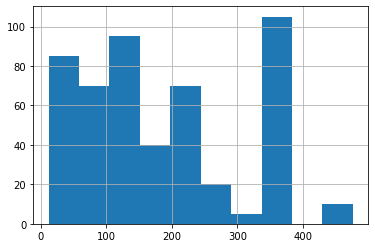

In [83]:
feat_df['vol'].hist()